# $\color{purple}{\text{Understanding Missing Data and How to Deal with It (Part 4)}}$

## $\color{purple}{\text{Common Treatment Practices}}$

### $\color{purple}{\text{Colab Environmental Setup}}$

### $\color{purple}{\text{Libraries for this lesson}}$

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import missingno
import numpy as np
plt.style.use('ggplot')
from helpers import stat_comparison
from autoimpute.imputations import SingleImputer

### $\color{purple}{\text{Load Datasets for this Lesson}}$
These datasets will be used for most of this section

In [4]:
pristine_df=pd.read_csv('data/full_set.csv')
mcar_df = pd.read_csv('data/mcar_set.csv')
mar_df = pd.read_csv('data/mar_set.csv')

### $\color{purple}{\text{Deletion}}$

Deletion is the most common form of treatment, but is the most susceptible to bias. It is intended to be used with MCAR mechanism. Some scenarios have guidelines where if the missingness is below a threshold then deletion bias is considered acceptable.

Deletion comes in two flavors, _list deletion_ and _pair deletion_

#### $\color{purple}{\text{List Deletion}}$
This is the simplest, you simply drop the records that have missing values

In [5]:
cleaned=mar_df.dropna()

In [6]:
stat_comparison( pristine_df, cleaned, 'feature a')

,Original,With Missing Data,difference,percentage
mean,2.367217,2.127196,0.240020,10.139349
median,2.380412,2.070274,0.310138,13.028759
stdev,1.280482,1.255276,0.025206,1.968470


#### $\color{purple}{\text{Pair Deletion}}$
Values are dropped if they are used. 
For example for covariance

$$\sigma_{ij} =\sum_{k} \frac{(x_{ik}-\mu_i)(x_{jk}-\mu_j)}{N^*} $$
where for all $k$ where $x_{ik}$ and $x_{jk}$ are not missing and $N^*$ is the count of all pairs where neither $x_{ik}$ and $x_{jk}$ are missing. This is how the the `cov` method deals with missing data

In [7]:
mar_df.cov()

,feature a,feature b,feature c,feature d,uncorrelated
feature a,1.575718,0.618051,1.493658,0.731672,-0.004067
feature b,0.618051,0.567885,0.592470,0.666410,-0.000740
feature c,1.493658,0.592470,1.641659,0.491526,-0.002669
feature d,0.731672,0.666410,0.491526,1.092563,-0.000852
uncorrelated,-0.004067,-0.000740,-0.002669,-0.000852,0.083923


In [8]:
mar_df.corr()

,feature a,feature b,feature c,feature d,uncorrelated
feature a,1.000000,0.656741,0.950822,0.557643,-0.011174
feature b,0.656741,1.000000,0.613613,0.846035,-0.003388
feature c,0.950822,0.613613,1.000000,0.367013,-0.007192
feature d,0.557643,0.846035,0.367013,1.000000,-0.002815
uncorrelated,-0.011174,-0.003388,-0.007192,-0.002815,1.000000


### $\color{purple}{\text{Interpolation}}$

If the rows have a geometric relationship (time-series, spatial relation), interpolation could be applied and the feature in question is thought to be continuous.

The interpolate dataset is constructed by sampling a continuous functions simulating a timeseries data.

Here is a little EDA on this set.

In [9]:
df=pd.read_csv('data/interpolate.csv')
df

,x,y,z
0,1.714373,NaN,NaN
1,5.798870,NaN,NaN
2,0.722063,NaN,NaN
3,0.212829,NaN,NaN
4,3.909096,-6.943405e-01,-0.719647
5,0.063520,NaN,NaN
6,2.964356,NaN,NaN
7,3.839445,NaN,NaN
8,4.703316,-9.999588e-01,-0.009072
9,2.527044,NaN,NaN


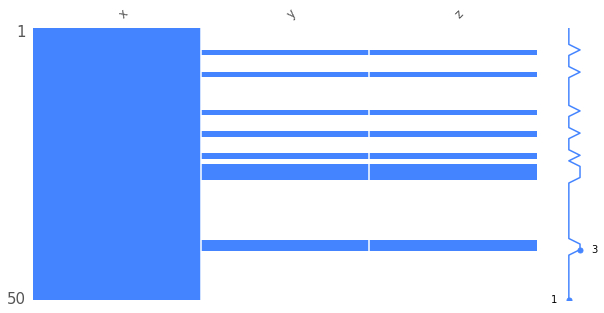

In [10]:
missingno.matrix(df, figsize=(10,5), fontsize=12, color=(0.27, 0.52, 1.0));

In [11]:
df.isnull().sum()

x     0
y    40
z    40
dtype: int64

We'll create a missing column so when we graph we can see the data that was interpolated. Also create a more attractive colormap for plotting.

In [12]:
df['missing']=df.y.isnull().astype(int)
cmap=matplotlib.colors.ListedColormap(['red', 'deepskyblue'])

#### $\color{purple}{\text{Back Fill/Forward Fill}}$

The simplest interpolation method (only applies to 1 dimension)

 * Forward Fill / Last Observation Forward
 * Back Fill / Next Observation Backward

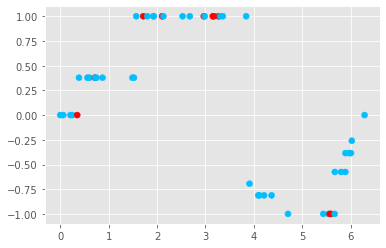

In [13]:
ndf=df.sort_values('x').fillna(method='ffill')
plt.scatter(ndf.x, ndf.y, cmap=cmap, c=df.missing)

#### $\color{purple}{\text{Other Interpolation Techniques}}$

Some types supported by `scipy`
* linear
* quadratic
* cubic

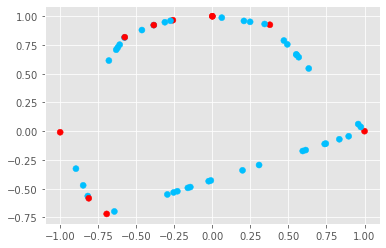

In [14]:
from scipy import interpolate
kind='linear'
ndf=df.copy()
interpolator_y = interpolate.interp1d(df.dropna().x, df.dropna().y, kind=kind)
ndf['y']=interpolator_y(ndf.x)
interpolator_z = interpolate.interp1d(df.dropna().x, df.dropna().z, kind=kind)
ndf['z']=interpolator_z(ndf.x)
plt.scatter(ndf.y, ndf.z, c=df.missing, cmap=cmap)

### $\color{purple}{\text{Univariate Imputation}}$
* Fill - Not recommended
    * `df.fillna(0)`
* Mean/Median
* Mode/Frequent
* Random

#### $\color{purple}{\text{Mean or Median Imputation}}$
For any column fill each missing value with the mean or the median of that feature
* Easy and quick
* Does not correct bias for MAR (or MNAR data)
* Induces a bias in variance a lower value


In [15]:
imputed_df = mar_df.fillna(mar_df['feature a'].mean())
stat_comparison( pristine_df, imputed_df, 'feature a')

,Original,With Missing Data,difference,percentage
mean,2.367217,2.127196,0.240020,10.139349
median,2.380412,2.127196,0.253216,10.637486
stdev,1.280482,1.124639,0.155843,12.170634


In [17]:
imputed_df = mar_df.fillna(mar_df['feature a'].median())
stat_comparison( pristine_df, imputed_df, 'feature a')

,Original,With Missing Data,difference,percentage
mean,2.367217,2.115965,0.251251,10.613777
median,2.380412,2.070274,0.310138,13.028759
stdev,1.280482,1.124867,0.155615,12.152819


In [18]:
# Use autoimpute
imputer=SingleImputer('mean')
imputed = imputer.fit_transform(mar_df)

In [19]:
stat_comparison( pristine_df, imputed, 'feature a')

,Original,With Missing Data,difference,percentage
mean,2.367217,2.127196,0.240020,10.139349
median,2.380412,2.127196,0.253216,10.637486
stdev,1.280482,1.124639,0.155843,12.170634


#### $\color{purple}{\text{Mode/Frequent Imputation}}$
For any column fill each missing value with the most frequent value 
* Same drawbacks as mean or median imputation for continuous values

In [46]:
cat_mar_df = pd.read_csv('data/categorical_mar.csv')

In [51]:
cat_mar_df.fillna(cat_mar_df['cat feature'].mode().iat[0])

,feature a,feature b,feature c,cat feature
0,-1.407780,2.469328,-0.530309,Cat A
1,15.752722,9.793495,9.382818,Cat C
2,-1.056187,1.978559,1.036313,Cat A
3,13.942551,9.976267,8.633593,Cat B
4,11.956025,7.871260,6.549692,Cat B
...,...,...,...,...
19995,0.667009,3.019559,1.400296,Cat A
19996,5.947251,8.087175,6.023416,Cat C
19997,12.211766,8.338764,15.438918,Cat C
19998,0.715749,2.312163,7.851357,Cat D


#### $\color{purple}{\text{Random/Normal}}$
Basically pick a random value based on the distribution of the rest of the column
* Advantage over median or mean imputation as it preserves the variance
* Still does not correct bias in MAR

In [20]:
filler=np.random.normal(mar_df['feature a'].mean(), mar_df['feature a'].std(), 20000)
imputed=mar_df.assign(**{'feature a': mar_df['feature a'].where(~mar_df['feature a'].isnull(), filler)})

In [21]:

stat_comparison( pristine_df, imputed_df, 'feature a')

,Original,With Missing Data,difference,percentage
mean,2.367217,2.115965,0.251251,10.613777
median,2.380412,2.070274,0.310138,13.028759
stdev,1.280482,1.124867,0.155615,12.152819


In [22]:
imputer=SingleImputer('norm')
imputed = imputer.fit_transform(mar_df)

In [45]:

stat_comparison( pristine_df, imputed, 'feature a')

,Original,With Missing Data,difference,percentate
mean,2.367217,2.115965,0.251251,10.613777
median,2.380412,2.070274,0.310138,13.028759
stdev,1.280482,1.124867,0.155615,12.152819


## $\color{purple}{\text{Takeaways}}$
* Interpolation can (and maybe should) be used in cases of spatial or time connected data features that are believed continuous
* Deletion and Univariate Imputation can be used for MCAR missingness or when the expected bias can be tolerated (i.e., very small amount of data missing)